# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [1]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

In [5]:
import pandas as pd


# FOR DEBUGGING: initializes paths according to the environment we're working on
try:
    import google.colab
    path_test = "/content/test.json"
    path_training = "/content/training.json"
    path_val = "/content/validation.json"
    print("sono su colab")

    !pip install transformers
    !pip install datasets
    !pip install accelerate -U
    !pip install evaluate
    !pip install bitsandbytes
except ImportError:
    path_test = "data\\test.json"
    path_training = "data\\training.json"
    path_val = "data\\validation.json"
    print("non sono su colab")


df_test = pd.read_json(path_test)
df_train = pd.read_json(path_training)
df_val = pd.read_json(path_val)

df_test = df_test.transpose()
df_train = df_train.transpose()
df_val = df_val.transpose()

sono su colab


In [6]:
df_train.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [7]:
df_test.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400178,400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_764, Annotator_765, Annotator_766, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400179,400179,en,“I like your outfit too except when i dress up...,6,"[Annotator_805, Annotator_426, Annotator_806, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, DIRECT, REPORTED, DIRECT, REPORT...","[[OBJECTIFICATION], [OBJECTIFICATION, MISOGYNY...",DEV_EN
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400181,400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, DIRECT]","[[-], [IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SE...",DEV_EN
400182,400182,en,@ultshunnie u gotta say some shit like “i’ll f...,6,"[Annotator_770, Annotator_771, Annotator_772, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, DIRECT, DIRECT, JUDGEMENTAL...","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [SEXUAL-V...",DEV_EN


In [8]:
df_val.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
300001,300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


In [9]:
def compute_hard_label(soft_labels):

    score = 0

    for v in soft_labels:

        if v == 'YES':
            score = score + 1

    return score


In [10]:
df_test['labels_task1'] = df_test['labels_task1'].apply(compute_hard_label)
df_train['labels_task1'] = df_train['labels_task1'].apply(compute_hard_label)
df_val['labels_task1'] = df_val['labels_task1'].apply(compute_hard_label)

df_val.head()


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
300001,300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",3,"[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",5,"[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",0,"[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",5,"[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",1,"[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


In [11]:
df_test_filtered = df_test.drop(df_test[df_test.labels_task1 == 3].index)
df_train_filtered = df_train.drop(df_train[df_train.labels_task1 == 3].index)
df_val_filtered = df_val.drop(df_val[df_val.labels_task1 == 3].index)


df_val_filtered.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",5,"[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",0,"[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",5,"[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",1,"[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES
300006,300006,es,On this #WorldPressFreedomDay I’m thinking of ...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]",1,"[-, -, -, -, -, JUDGEMENTAL]","[[-], [-], [-], [-], [-], [STEREOTYPING-DOMINA...",DEV_ES


In [12]:
df_test_filtered.loc[df_test_filtered.labels_task1 > 3, 'labels_task1'] = 1
df_test_filtered.loc[df_test_filtered.labels_task1 != 1, 'labels_task1'] = 0

df_train_filtered.loc[df_train_filtered.labels_task1 > 3, 'labels_task1'] = 1
df_train_filtered.loc[df_train_filtered.labels_task1 != 1, 'labels_task1'] = 0

df_val_filtered.loc[df_val_filtered.labels_task1 > 3, 'labels_task1'] = 1
df_val_filtered.loc[df_val_filtered.labels_task1 != 1, 'labels_task1'] = 0



In [13]:
df_train_filtered.drop(df_train_filtered[df_train_filtered.lang == 'es'].index, inplace=True)
df_val_filtered.drop(df_val_filtered[df_val_filtered.lang == 'es'].index, inplace=True)
df_test_filtered.drop(df_test_filtered[df_test_filtered.lang == 'es'].index, inplace=True)

In [14]:
#check language es is not present
print(df_train_filtered['lang'].unique())
print(df_val_filtered['lang'].unique())
print(df_test_filtered['lang'].unique())

['en']
['en']
['en']


In [15]:
columns_to_drop = ['annotators','number_annotators','gender_annotators','age_annotators','labels_task2','labels_task3','split']
df_train_filtered.drop(columns=columns_to_drop, inplace=True)
df_val_filtered.drop(columns=columns_to_drop, inplace=True)
df_test_filtered.drop(columns=columns_to_drop, inplace=True)

In [16]:
df_train_filtered.rename(columns={'labels_task1': 'hard_labels_task1'}, inplace=True)
df_val_filtered.rename(columns={'labels_task1': 'hard_labels_task1'}, inplace=True)
df_test_filtered.rename(columns={'labels_task1': 'hard_labels_task1'}, inplace=True)

In [17]:
df_train_filtered.columns

Index(['id_EXIST', 'lang', 'tweet', 'hard_labels_task1'], dtype='object')

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [18]:
import re
# urls-> http
# hashtags -> #
# mentions -> @
# emojis -> \ud
# special characters -> \ or &


def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"\\u\S+", "", text)
    text = re.sub(r"&\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9 ]+", " ", text)
    return text

df_train_filtered_reg = df_train_filtered.copy()
df_val_filtered_reg = df_val_filtered.copy()
df_test_filtered_reg = df_test_filtered.copy()


df_train_filtered_reg['tweet'] = df_train_filtered['tweet'].apply(clean_text)
df_val_filtered_reg['tweet'] = df_val_filtered['tweet'].apply(clean_text)
df_test_filtered_reg['tweet'] = df_test_filtered['tweet'].apply(clean_text)

bring everything to lower case otherwise lemmatization is not working

In [19]:
df_train_filtered_reg['tweet'] = df_train_filtered_reg['tweet'].str.lower()
df_val_filtered_reg['tweet'] = df_val_filtered_reg['tweet'].str.lower()
df_test_filtered_reg['tweet'] = df_test_filtered_reg['tweet'].str.lower()

In [20]:
print(df_test_filtered_reg['tweet'].iloc[3])

  fuck that cunt  tried to vote her out multiple times


In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, WhitespaceTokenizer

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [22]:
def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

df_train_filtered_lem = df_train_filtered_reg.copy()
df_val_filtered_lem = df_val_filtered_reg.copy()
df_test_filtered_lem = df_test_filtered_reg.copy()

df_train_filtered_lem['tweet'] = df_train_filtered_reg['tweet'].apply(lem_text)
df_val_filtered_lem['tweet'] = df_val_filtered_reg['tweet'].apply(lem_text)
df_test_filtered_lem['tweet'] = df_test_filtered_reg['tweet'].apply(lem_text)

In [23]:
id = 2
print(df_test_filtered_reg['tweet'].iloc[id])
print(df_test_filtered_lem['tweet'].iloc[id])

   same  though  the angst just comes and goes  lonely xie lian will always break my frigid heart 
same though the angst just come and go lonely xie lian will always break my frigid heart


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [24]:
from collections import OrderedDict
from typing import Dict, List

def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 0
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [25]:
idx_to_word_train, word_to_idx_train, word_listing_train = build_vocabulary(df_train_filtered_lem)

100%|██████████| 2870/2870 [00:00<00:00, 194825.00it/s]


In [26]:
print(f"[Debug] Length of the vocabulary: {len(idx_to_word_train)}")
print(f'[Debug] Some words: {[(idx_to_word_train[idx], idx) for idx in np.arange(10)]}')

[Debug] Length of the vocabulary: 9051
[Debug] Some words: [('write', 0), ('a', 1), ('uni', 2), ('essay', 3), ('in', 4), ('my', 5), ('local', 6), ('pub', 7), ('with', 8), ('coffee', 9)]


In [27]:
def evaluate_vocabulary(idx_to_word: Dict[int, str], word_to_idx: Dict[str, int],
                        word_listing: List[str], df: pd.DataFrame, check_default_size: bool = False):
    print("[Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("[Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("[Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    print("[Vocabulary Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        'tweet': ["all that glitters is not gold", "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df)
    toy_valid_vocabulary = set(' '.join(toy_df.tweet.values).split())
    assert set(toy_word_listing) == toy_valid_vocabulary

In [28]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_train, word_to_idx_train, word_listing_train, df_train_filtered_lem)
print("Evaluation completed!")

Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 9051/9051 [00:00<00:00, 1950302.88it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 2870/2870 [00:00<00:00, 203208.29it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 3720.00it/s]

Evaluation completed!


After building the vocabulary for training set, it's time to encode the words. We will use GloVE.

In [29]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

Loading the GloVe embedding model. Choosing 50 as embedding dimension (can be adapted).

In [30]:
embedding_model = load_embedding_model(model_type='glove', embedding_dimension=50)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [31]:
print(embedding_model)

KeyedVectors<vector_size=50, 400000 keys>


In [32]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [33]:
oov_train = check_OOV_terms(embedding_model, word_listing_train)

print(f"Len of training vocabulary: {len(word_listing_train)}")
print(f"Number of OOV words: {len(oov_train)}")
print(oov_train)

oov_percentage = float(len(oov_train)) * 100 / len(word_listing_train)
print(f"Total OOV terms: {len(oov_train)} ({oov_percentage:.2f}%)")

Len of training vocabulary: 9051
Number of OOV words: 932
['ibang', 'cecilt', 'gobbily', 'kaizenix', 'foebut', '38original', 'nollaigh', 'dumbass', 'reify', 'canva', 'stockholme', 'retweets', 'doinks', 'ddd06jan', 'bidmc', 'futanari', 'ao3', 'catcall', 'hazviite', 'smartnews', 'cumdump', 'socials10', 'quinary', 'kinju', 'carousel30', 'digusting', 'cissexist', 'vaccinatedour', 'alreadyeither', 'mansplain', 'adorama', 'suburan', 'upstander', 'pandra', 'glanzer', 'timehop', 'straigh', 'lollll', 'tianlang', 'twtjesus', 'yhoo', 'nevee', 'ortakolma', 'womensday', 'ridah', 'gangbanged', 'gine', 'unfollowed', 'endsars', 'woman4', 'malchaamah', 'becloud', 'jikook', 'ngang', 'kendis', 'econmy', 'jo1', 'homosapiens', 'kikyuuseinfact', 'neolocal', 'terf', 'sofoulis', 'akaabir', 'catastrophizing', 'sanctomony', 'lustwhat', 'melow', 'alaih', 'bitvh', 'ranchu', 'kep1e', 'funfetti', 'gajab', 'womani', 'immerwahr', 'shouldve', 'antivax', 'feminazis', 'castrat3d', 'deffend', 'lolz', 'slsjsu', 'ambitionz

We now have to create the embedding matrix for training set.


In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            # creating custom embedding for oov words
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
# Testing
embedding_dimension = 50
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx_train, len(word_to_idx_train), oov_train)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Adding [UNK] token to our vocabulary.

In [ ]:
word_listing_train.append('[UNK]')
idx_to_word_train[len(idx_to_word_train)] = '[UNK]'
word_to_idx_train['[UNK]'] = len(idx_to_word_train)-1


In [ ]:
# DEBUG
print(idx_to_word_train[len(idx_to_word_train)-1])
print(len(idx_to_word_train))
print(len(word_listing_train))
print(len(word_to_idx_train))
print(word_to_idx_train['[UNK]'])

In [ ]:
unk_embedding = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

print(embedding_matrix.shape)
embedding_matrix = np.vstack([embedding_matrix, unk_embedding])

In [ ]:
print(embedding_matrix.shape)

In [ ]:
df_train_filtered_lem.head()

In [ ]:
df_test_filtered_lem.head()

In [ ]:
df_val_filtered_lem.head()

# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [ ]:

# embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
#                                       output_dim=embedding_dimension,
#                                       weights=[embedding_matrix],
#                                       mask_zero=True,                   # automatically masks padding tokens
#                                       name='encoder_embedding')


### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [ ]:
# TODO: NEVER USED FUNCTION
def one_hot_encode(index, vocab_size):
    """
    Create a one-hot encoding vector given an index.

    Parameters:
    - index (int): The index of the word in the vocabulary.
    - vocab_size (int): The size of the vocabulary.

    Returns:
    - np.array: A one-hot encoded vector of size (vocab_size,).
    """
    if index >= vocab_size or index < 0:
        raise ValueError("Index out of range for the given vocabulary size.")

    # Initialize a zero vector
    one_hot_vector = np.zeros(vocab_size, dtype=int)

    # Set the index position to 1
    one_hot_vector[index] = 1

    return one_hot_vector


In [ ]:
def seq_to_index(tweet, word_to_idx):

    result = []

    for word in tweet.split():
        idx = word_to_idx.get(word, word_to_idx['[UNK]'])
        result.append(idx)

    return result

result = seq_to_index(df_train_filtered_lem['tweet'].iloc[0], word_to_idx_train)

print(result)
print(len(one_hot_encode(result[0], 9052)))
# one hot encoding of first word: id=1
print(one_hot_encode(result[0], 9052))

In order to find the longest tweet. # FIXED!!  
before we were counting the characters, not the tokens.

In [ ]:
def longest_tweet(X, word_to_idx):
    tweets_to_seq = []

    for tweet in list(X):
        tweets_to_seq.append(seq_to_index(tweet, word_to_idx))

    # longest_tweet_size = X.map(lambda x: len(x)).max() # THIS RETURNS THE MAX NUMBER OF CHARACTERS
    longest_tweet_size = max([len(tweet) for tweet in tweets_to_seq])

    return longest_tweet_size

In [ ]:
longest_tweet_size = max([longest_tweet(df_train_filtered_lem['tweet'], word_to_idx_train),
                            longest_tweet(df_val_filtered_lem['tweet'], word_to_idx_train),
                            longest_tweet(df_test_filtered_lem['tweet'], word_to_idx_train)])

In [ ]:
longest_tweet_size

We need to create a class for every model and then instantiate them

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Masking, Input

In [ ]:
class Baseline(Model):
    def __init__(self, longest_tweet_size, embedding_dimension):
        super().__init__()
        self.input_shape = (None, longest_tweet_size, embedding_dimension)
        self.masking = Masking(mask_value=0)
        self.bidirectional_lstm = Bidirectional(LSTM(units=64, return_sequences=False, dropout=0.5))
        self.classifier = Dense(units=1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.masking(inputs)
        x = self.bidirectional_lstm(x)
        return self.classifier(x)

    def build_model(self):
        self.masking.build(self.input_shape)
        self.bidirectional_lstm.build(self.masking.compute_output_shape(self.input_shape))
        self.classifier.build(self.bidirectional_lstm.compute_output_shape(self.input_shape))

In [ ]:
class Model1(Model):
    def __init__(self, longest_tweet_size, embedding_dimension):
        super().__init__()
        self.input_shape = (None, longest_tweet_size, embedding_dimension)
        self.masking = Masking(mask_value=0)
        self.bidirectional_lstm_1 = Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.5)) # return_sequences=True becasue we want to pass the output to the next LSTM
        self.bidirectional_lstm_2 = Bidirectional(LSTM(units=32, return_sequences=False, dropout=0.5))
        self.classifier = Dense(units=1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.masking(inputs)
        x = self.bidirectional_lstm_1(x)
        x = self.bidirectional_lstm_2(x)
        return self.classifier(x)

    def build_model(self):
        self.masking.build(self.input_shape)
        self.bidirectional_lstm_1.build(self.masking.compute_output_shape(self.input_shape))
        self.bidirectional_lstm_2.build(self.bidirectional_lstm_1.compute_output_shape(self.input_shape))
        self.classifier.build(self.bidirectional_lstm_2.compute_output_shape(self.input_shape))

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [47]:
from sklearn.metrics import f1_score

def f1_score_custom(precision, recall):
    return  2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    precision = np.array(history.history['precision'])
    val_precision = np.array(history.history['val_precision'])
    recall = np.array(history.history['recall'])
    val_recall = np.array(history.history['val_recall'])

    epochs = range(1, len(precision) + 1)

    # Plotting the loss
    ax1.plot(epochs, history.history['loss'], label='Training Loss')
    ax1.plot(epochs, history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.legend()
    ax1.grid(True)

    # Plotting F1 score
    ax2.plot(epochs, f1_score_custom(precision, recall), label='Training F1 Score')
    ax2.plot(epochs, f1_score_custom(val_precision, val_recall), label='Validation F1 Score')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Score Over Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Here we compute the maximum length for the specific dataset. let's think of using the maximum length among all the splits (train, val, test) so the one defined above

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def create_padded_dataset(initial_dataset, word_to_idx):
    tweets_to_seq = []

    for tweet in list(initial_dataset):
        tweets_to_seq.append(seq_to_index(tweet, word_to_idx))


    # Traduci le sequenze in sequenze di vettori
    X = [[embedding_matrix[idx] for idx in tweet] for tweet in tweets_to_seq]

    # longest_tweet_size = initial_dataset.map(lambda x: len(x)).max() # THIS RETURNS THE MAX NUMBER OF CHARACTERS
    longest_tweet_size = max([len(tweet) for tweet in X])

    # TO CHECK: how to generate output once for each tweet in a batch
    # TO CHECK: also, maxlen=longest_tweet_size or maxlen=longest_tweet_size+1?
    X_padded = pad_sequences(X, maxlen=longest_tweet_size, dtype='float64', padding='post', value=0)

    # we can see the tweet has been padded
    # and we can see that the word has been encoded with appropriate glove vector
    # print(X_padded[0][0])
    # print(X_padded[0][-1])
    # print(embedding_matrix[0])

    # shape: n_tweets x max_length_tweet x embedding_dimension
    # print(X_train_padded.shape)
    return X_padded

In [ ]:
X_train_padded = create_padded_dataset(df_train_filtered_lem['tweet'], word_to_idx_train)

In [ ]:
X_val = create_padded_dataset(df_val_filtered_lem['tweet'], word_to_idx_train)

In [ ]:
y_train = np.array(df_train_filtered_lem['hard_labels_task1'])
y_val = np.array(df_val_filtered_lem['hard_labels_task1'])


In [ ]:
print(X_train_padded.shape)
print(y_train.shape)

(2870, 62, 50)
(2870,)


In [ ]:
print(X_val.shape)
print(y_val.shape)

(158, 57, 50)
(158,)


In [ ]:
# setting the seed for training
tf.random.set_seed(50)

In [ ]:
baseline = Baseline(longest_tweet_size, embedding_dimension)
baseline.build_model()
baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision', 'recall'])
baseline.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 62, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,009 (230.50 KB)

 Trainable params: 59,009 (230.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
baseline_history = baseline.fit(x=X_train_padded, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.6769 - precision: 0.5949 - recall: 0.8673 - val_loss: 0.6694 - val_precision: 0.6542 - val_recall: 0.7143
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6451 - precision: 0.6515 - recall: 0.8247 - val_loss: 0.6768 - val_precision: 0.6471 - val_recall: 0.6735
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6330 - precision: 0.6569 - recall: 0.8133 - val_loss: 0.6449 - val_precision: 0.6875 - val_recall: 0.6735
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6195 - precision: 0.6815 - recall: 0.8023 - val_loss: 0.6363 - val_precision: 0.6944 - val_recall: 0.7653
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6163 - precision: 0.6839 - recall: 0.8228 - val_loss: 0.6134 - val_precision: 0.7000 - val_recall: 0.7143
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6161 - precision: 0.6848 - recall: 0.8055 - val_loss: 0.6793 - val_precision: 0.6538 - val_recall: 0.693

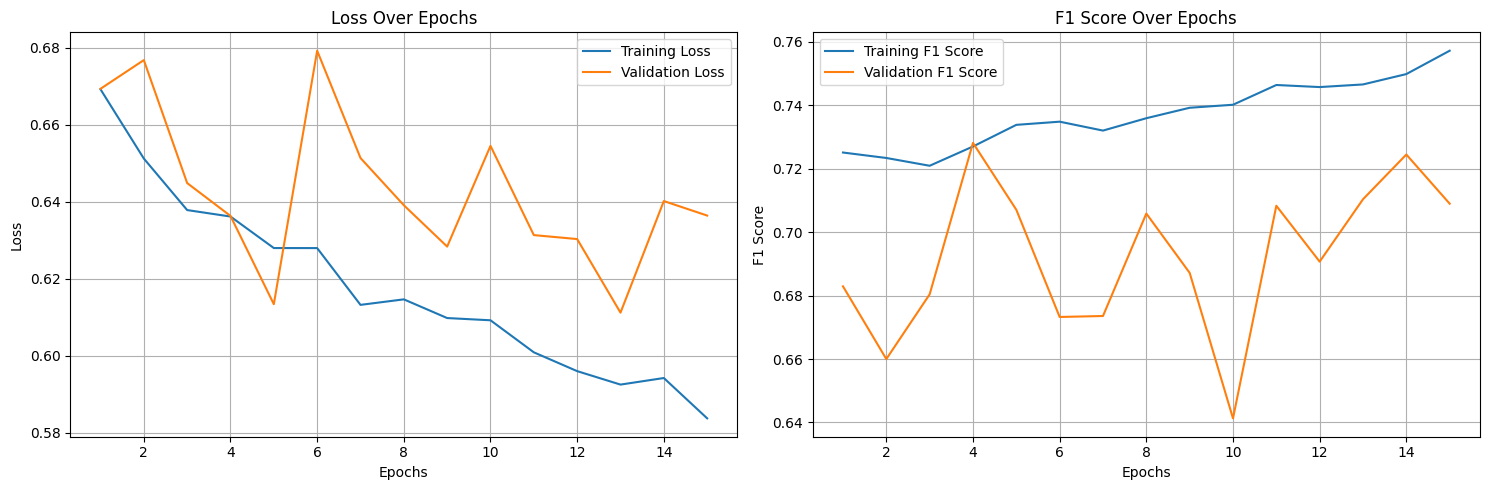

In [ ]:
plot_training(baseline_history)

In [ ]:
X_test = create_padded_dataset(df_test_filtered_lem['tweet'], word_to_idx_train)
y_test = np.array(df_test_filtered_lem['hard_labels_task1'])

In [ ]:
y_pred = (baseline.predict(X_test) > 0.5).astype("int32")

# Calcolo del F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
F1-Score: 0.7430167597765364


Let's create a new model, with one more Bidirectional LSTM Layer.

In [ ]:
model1 = Model1(longest_tweet_size, embedding_dimension)
model1.build_model()
# model1.build(input_shape=(None, longest_tweet_size, embedding_dimension))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['precision', 'recall'])
model1.summary()

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 62, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 62, 128)             │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,161 (391.25 KB)

 Trainable params: 100,161 (391.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1_history = model1.fit(x=X_train_padded, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.6806 - precision: 0.6027 - recall: 0.8929 - val_loss: 0.6663 - val_precision: 0.6990 - val_recall: 0.7347
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6526 - precision: 0.6409 - recall: 0.8367 - val_loss: 0.6559 - val_precision: 0.6881 - val_recall: 0.7653
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.6345 - precision: 0.6642 - recall: 0.8175 - val_loss: 0.6400 - val_precision: 0.6700 - val_recall: 0.6837
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6332 - precision: 0.6791 - recall: 0.7680 - val_loss: 0.6288 - val_precision: 0.6944 - val_recall: 0.7653
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.6228 - precision: 0.6835 - recall: 0.8147 - val_loss: 0.6514 - val_precision: 0.6989 - val_recall: 0.6633
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6200 - precision: 0.6811 - recall: 0.7981 - val_loss: 0.6394 - val_precision: 0.7010 - val_recall: 0.693

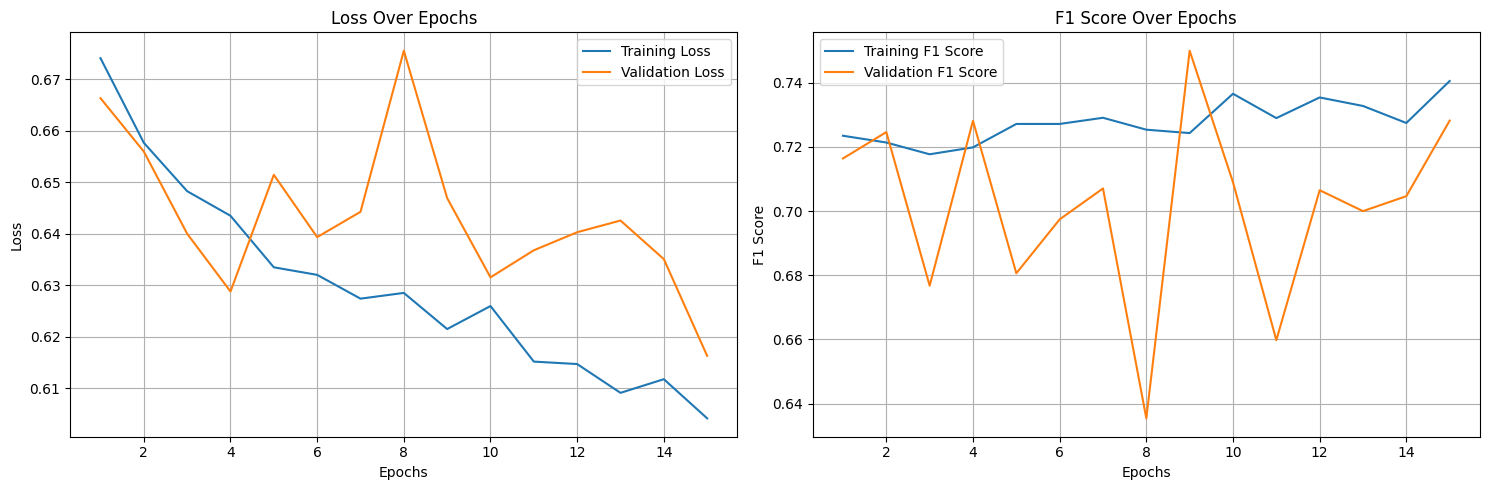

In [ ]:
plot_training(model1_history)

In [ ]:
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

# Calcolo del F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
F1-Score: 0.7277486910994765


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [78]:
def clean_text_transformer(text): # with transformer we want to keep some special characters.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"\\u\S+", "", text)
    text = re.sub(r"&\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9.,!? ]+", " ", text)
    text = re.sub(r'\s+', ' ', text) # to remove redundant whitespaces
    return text

df_train_filtered_transformer = df_train_filtered.copy()
df_val_filtered_transformer = df_val_filtered.copy()
df_test_filtered_transformer = df_test_filtered.copy()


df_train_filtered_transformer['tweet'] = df_train_filtered_transformer['tweet'].apply(clean_text_transformer)#.str.lower()
df_val_filtered_transformer['tweet'] = df_val_filtered_transformer['tweet'].apply(clean_text_transformer)#.str.lower()
df_test_filtered_transformer['tweet'] = df_test_filtered_transformer['tweet'].apply(clean_text_transformer)#.str.lower()


In [79]:
from datasets import Dataset

# train_data = Dataset.from_pandas(df_train_filtered_reg)
# test_data = Dataset.from_pandas(df_test_filtered_reg)
# val_data = Dataset.from_pandas(df_val_filtered_reg)

train_data = Dataset.from_pandas(df_train_filtered_transformer)
test_data = Dataset.from_pandas(df_test_filtered_transformer)
val_data = Dataset.from_pandas(df_val_filtered_transformer)

# DEBUG
print(train_data)
print(test_data)
print(val_data)

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_labels_task1', '__index_level_0__'],
    num_rows: 2870
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_labels_task1', '__index_level_0__'],
    num_rows: 286
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_labels_task1', '__index_level_0__'],
    num_rows: 158
})


In [67]:
from transformers import AutoTokenizer

model_card = 'cardiffnlp/twitter-roberta-base-hate'

tokenizer = AutoTokenizer.from_pretrained(model_card)


In [80]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

train_data = train_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)

# DEBUG
print(train_data)
print(test_data)
print(val_data)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_labels_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_labels_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 286
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_labels_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 158
})


In [81]:
# DEBUG
# converted the 'text' into a sequence of indexes.
print(train_data['input_ids'][5])
print(len(train_data['input_ids'][5]))
print(len(train_data['input_ids']))
print(train_data['attention_mask'][5])


[0, 100, 4443, 14, 579, 5342, 2340, 13, 10, 39561, 27534, 1437, 2]
13
2870
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [82]:
# performing a quick sanity check

original_text = train_data['tweet'][5]
decoded_text = tokenizer.decode(train_data['input_ids'][5])

# [CLS] = Classify Token

print(original_text)
print()
print()
print(decoded_text)

I guess that s fairly normal for a Neanderthal 


<s>I guess that s fairly normal for a Neanderthal </s>


In [83]:
tokenizer.tokenize(original_text)

['I',
 'Ġguess',
 'Ġthat',
 'Ġs',
 'Ġfairly',
 'Ġnormal',
 'Ġfor',
 'Ġa',
 'ĠNeander',
 'thal',
 'Ġ']

In [84]:
# TODO: do we need to handle any OOV words? add_tokens?
new_tokens = oov_train
num_added_tokens = tokenizer.add_tokens(new_tokens)
print(f"Added {num_added_tokens} new tokens to the tokenizer.")


len(tokenizer.vocab)

Added 0 new tokens to the tokenizer.


51195

In [85]:
from transformers import AutoModelForSequenceClassification

# check the mapping: do we really need it?
model = AutoModelForSequenceClassification.from_pretrained(model_card, num_labels=2, id2label={0: 'NO', 1: 'YES'}, label2id={'NO': 0, 'YES': 1})

print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [86]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [87]:
from sklearn.metrics import accuracy_score

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}


# alternatively, we could use Huggingface evaluate package

In [ ]:
'''
import evaluate

acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return {**f1, **acc}
'''

In [88]:
train_data = train_data.rename_column('hard_labels_task1', 'label')
test_data = test_data.rename_column('hard_labels_task1', 'label')
val_data = val_data.rename_column('hard_labels_task1', 'label')


In [89]:

from transformers import TrainingArguments
from sklearn.model_selection import ParameterGrid
from transformers import Trainer

learning_rate=1e-5
batch_size=32
num_train_epochs=5
weight_decay=0.1




training_args = TrainingArguments(
    output_dir="test_dir",                 # where to save model
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,         # batch size
    per_device_eval_batch_size=batch_size,          # batch size
    num_train_epochs=num_train_epochs,             # number of epochs
    weight_decay=weight_decay,
    evaluation_strategy="epoch",           # when to report evaluation metrics/losses
    save_strategy="epoch",                 # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                      # disabling wandb (default)
    )

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_data,
  eval_dataset=test_data,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

trainer.train()

metrics = trainer.evaluate()




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-89-f9a00eef5399>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# tried to implement a grid search

from transformers import TrainingArguments
from sklearn.model_selection import ParameterGrid
from transformers import Trainer

# we need a grid search to find best hyperparameters

param_grid = {
    "learning_rate": [1e-5, 2e-5, 5e-5],
    "batch_size": [8, 16, 32],
    "num_train_epochs": [1],
    "weight_decay": [0.01, 0.1],
}


best_loss = np.inf
best_params = None

for param in ParameterGrid(param_grid):

  training_args = TrainingArguments(
      output_dir="test_dir",                 # where to save model
      learning_rate=param['learning_rate'],
      per_device_train_batch_size=param['batch_size'],         # batch size
      per_device_eval_batch_size=param['batch_size'],          # batch size
      num_train_epochs=param['num_train_epochs'],             # number of epochs
      weight_decay=param['weight_decay'],
      evaluation_strategy="epoch",           # when to report evaluation metrics/losses
      save_strategy="epoch",                 # when to save checkpoint
      load_best_model_at_end=True,
      report_to='none'                       # disabling wandb (default)
  )

  print("learning_rate: ", param['learning_rate'])
  print("batch_size: ", param['batch_size'])
  print("num_train_epochs: ", param['num_train_epochs'])
  print("weight_decay: ", param['weight_decay'])

  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
  )

  trainer.train()

  metrics = trainer.evaluate()

  if metrics["eval_loss"] < best_loss:
      best_loss = metrics["eval_loss"]
      best_params = param

print(f"Best hyperparameters: {best_params}")
print(f"Best loss: {best_loss}")



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  1e-05
batch_size:  8
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.597985,0.717333,0.734266


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  1e-05
batch_size:  8
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.880045,0.710887,0.730769


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  2e-05
batch_size:  8
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.048677,0.730853,0.744755


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  2e-05
batch_size:  8
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.499103,0.740714,0.751748


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  5e-05
batch_size:  8
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.326425,0.741477,0.755245


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  5e-05
batch_size:  8
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.896684,0.709729,0.730769


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  1e-05
batch_size:  16
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.185411,0.732347,0.751748


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  1e-05
batch_size:  16
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.628265,0.726882,0.748252


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  2e-05
batch_size:  16
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,2.459414,0.733167,0.748252


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  2e-05
batch_size:  16
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,2.644622,0.732210,0.748252


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  5e-05
batch_size:  16
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.178253,0.705907,0.716783


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  5e-05
batch_size:  16
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.773449,0.699148,0.713287


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  1e-05
batch_size:  32
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,1.833523,0.699027,0.720280


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  1e-05
batch_size:  32
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,2.346817,0.694650,0.716783


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  2e-05
batch_size:  32
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,3.299731,0.702455,0.720280


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  2e-05
batch_size:  32
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,3.550668,0.706705,0.723776


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  5e-05
batch_size:  32
num_train_epochs:  1
weight_decay:  0.01


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,3.723876,0.718343,0.734266


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-d7d3d6fd346c>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


learning_rate:  5e-05
batch_size:  32
num_train_epochs:  1
weight_decay:  0.1


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End